# 5.Advance Modeling<a id='5.Advance Modeling Part B'></a>


## 5.1 Contents<a id='5.1_Contents'></a>

  * [5.2 Introduction](#5.2_Introduction)   
  * [5.3 Load The Data](#5.3_Load_The_Data)  
  * [5.4 SHAP Feature importance](#5.4_SHAP_Feature_importance)  
  * [5.5 SHAP Summary Plot](#5.5_SHAP_Summary_Plot)      
  * [5.6 SHAP Dependence Plot](#5.6_SHAP_Dependence_Plott)
  * [5.7 SHAP Decision ](#5.7_SHAP_Decision)  
  * [5.8  SHAP Decision plot all features](#5.8_SHAP_Decision_plot_all_features)
  * [5.9 SHAP force plot](#5.9_SHAP_force_plot)
  * [5.10 Summary](#5.10_Summary)

## 5.2 Introduction<a id='5.2_Introduction'></a>

This notebook focuses on using the SHAP (SHapley Additive exPlanations) framework to analyze feature contributions in predicting house prices. By leveraging SHAP, we aim to gain a deeper understanding of the relative importance of each predictor. The notebook begins by loading the train and test house price dataset, ensuring data quality and relevance. We then generate a SHAP feature importance plot, ranking the top predictors and establishing their hierarchy of importance. Additionally, we employ various SHAP plots, including summary plots, dependence plots, decision plots, and force plots, to further analyze the relationships between key features and house prices. Through this analysis, we uncover how changes in features such as overall quality, garage size, and kitchen quality impact house prices positively or negatively. The insights gained from this notebook can enhance decision-making in the real estate market by providing a data-driven understanding of the factors driving house prices.

In [1]:

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from matplotlib.gridspec import GridSpec
import pickle
from sklearn.ensemble import RandomForestRegressor

from sklearn import ensemble
import shap
#pip install shap
#shap.initjs()

## 5.3 Load The Data<a id='5.3_Load_The_Data'></a>

In [2]:
X_train = pd.read_pickle("./cleaned_data/X_tr_scaled.pkl") #X_tr_scaled.to_pickle("./cleaned_data/X_tr_scaled.pkl") 

In [3]:
X_test= pd.read_pickle("./cleaned_data/X_te_scaled.pkl") #X_te_scaled.to_pickle("./cleaned_data/X_te_scaled.pkl")

In [4]:
y_train= pd.read_pickle("./cleaned_data/y_train.pkl") #y_train.to_pickle("./cleaned_data/y_train.pkl")

In [5]:
y_test = pd.read_pickle("./cleaned_data/y_test.pkl") #y_test.to_pickle("./cleaned_data/y_test.pkl")

In [6]:
X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.799560,0.181850,-0.817582,-0.539845,-0.757948,1.420006,0.155143,-0.285105,0.394301,0.494614,...,-0.070117,-0.306950,-0.044281,0.404980,-0.275299,-0.054259,-0.062684,-0.117851,0.465475,-0.308855
1,0.321904,-0.314372,-1.550537,1.263166,-1.670795,-0.574380,-1.012563,-0.285105,0.108479,-1.091242,...,-0.070117,-0.306950,-0.044281,0.404980,-0.275299,-0.054259,-0.062684,-0.117851,0.465475,-0.308855
2,-0.872237,-0.129258,0.648328,-0.539845,0.875568,-0.574380,-1.012563,-0.285105,2.236268,1.285008,...,-0.070117,-0.306950,-0.044281,0.404980,-0.275299,-0.054259,-0.062684,-0.117851,0.465475,-0.308855
3,0.321904,1.552023,-0.084627,0.361661,-1.670795,-0.574380,1.621781,-0.285105,-0.753526,0.803678,...,-0.070117,-0.306950,-0.044281,0.404980,-0.275299,-0.054259,-0.062684,-0.117851,0.465475,-0.308855
4,0.083076,-0.000721,0.648328,0.361661,1.067746,-0.574380,-1.012563,-0.285105,0.680123,-0.452846,...,-0.070117,3.257858,-0.044281,-2.469255,-0.275299,-0.054259,-0.062684,-0.117851,-2.148345,3.237769


In [7]:
X_test.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.872237,0.590728,0.648328,-0.539845,1.019701,-0.428052,-1.012563,-0.285105,2.485795,1.563673,...,-0.070117,3.257858,-0.044281,-2.469255,-0.275299,-0.054259,-0.062684,-0.117851,-2.148345,3.237769
1,-0.872237,-0.344885,0.648328,-0.539845,0.971657,-0.574380,-0.055044,-0.285105,0.537212,0.426214,...,-0.070117,-0.306950,-0.044281,0.404980,-0.275299,-0.054259,-0.062684,-0.117851,0.465475,-0.308855
2,0.560732,-0.151635,-0.084627,-0.539845,-0.998171,0.829278,0.444734,1.843307,-0.649178,0.494614,...,-0.070117,-0.306950,-0.044281,0.404980,-0.275299,-0.054259,-0.062684,-0.117851,0.465475,-0.308855
3,-0.872237,0.315218,1.381283,-0.539845,0.395122,-0.574380,1.862328,-0.285105,3.164056,5.439645,...,-0.070117,-0.306950,-0.044281,0.404980,-0.275299,-0.054259,-0.062684,-0.117851,0.465475,-0.308855
4,2.471358,-0.959601,-0.817582,0.361661,-0.373591,-0.574380,0.267242,0.810774,-1.220822,-0.749244,...,-0.070117,-0.306950,-0.044281,0.404980,-0.275299,-0.054259,-0.062684,-0.117851,0.465475,-0.308855


[<a href="#5.Advance Modeling Part B">Back to top</a>]

In [8]:
y_train.head()

,SalePrice
1350,200000
1408,125500
276,201000
417,239000
686,227875


In [9]:
y_test.head()

,SalePrice
0,240000
1,185000
2,168500
3,430000
4,127000


In [10]:
y_train = np.ravel(y_train) #change to array
y_test = np.ravel(y_test)

In [11]:
# initiate the RandomForestRegressor model
model = ensemble.RandomForestRegressor() # (max_depth=6, random_state=0, n_estimators=10)

model.fit(X_train, y_train);

In [12]:

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)


## 5.4 SHAP Feature importance<a id='5.4_SHAP_Feature_importance'></a>

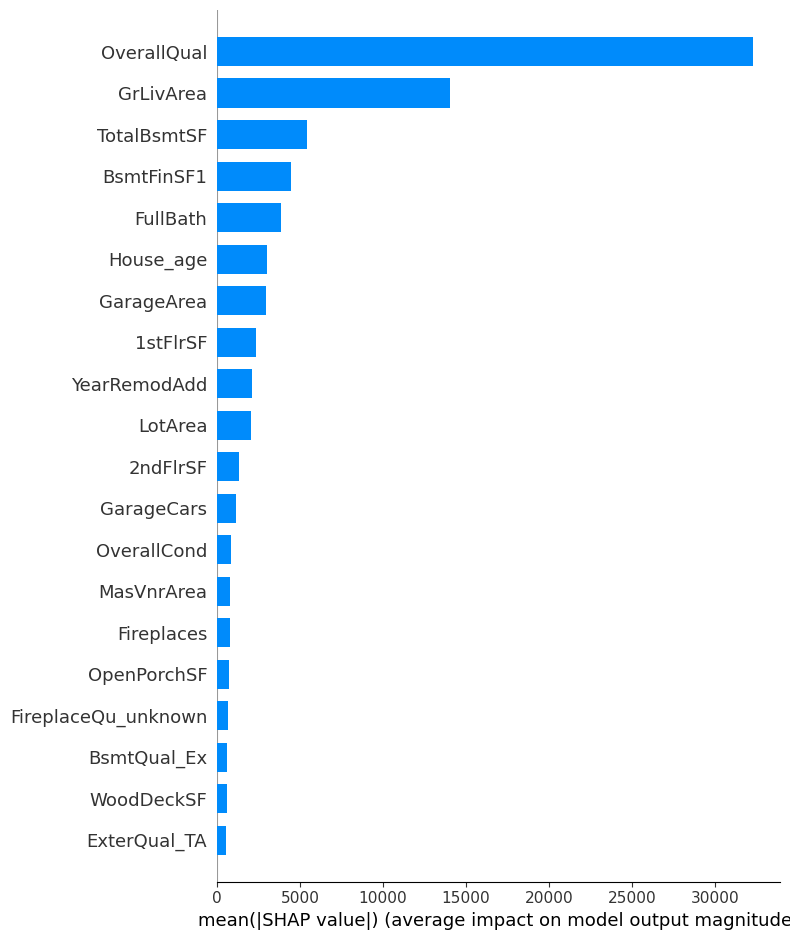

In [13]:
#shap_values = shap.TreeExplainer(model).shap_values(X_train)
#Variable Importance Plot — Global Interpretability
shap.summary_plot(shap_values, X_train, plot_type="bar")



[<a href="#5.Advance Modeling Part B">Back to top</a>]

## 5.5 SHAP Summary Plot<a id='5.5_Shap_Summary_plot'></a>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


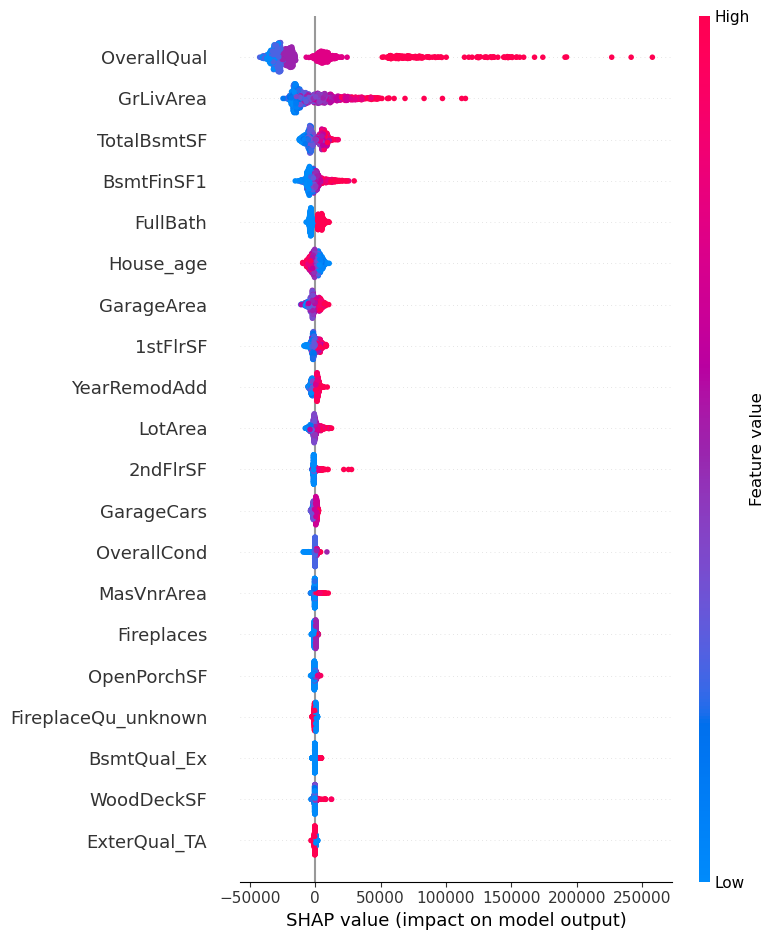

In [14]:
shap.summary_plot(shap_values, X_train)

#save the figure
f = plt.figure()
shap.summary_plot(shap_values, X_train)
f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=1022)

## 5.6 SHAP Dependence Plot<a id='5.6_Shap_Dependence_Plot'></a>

The SHAP value plot can show the positive and negative relationships of the predictors with the target variable.

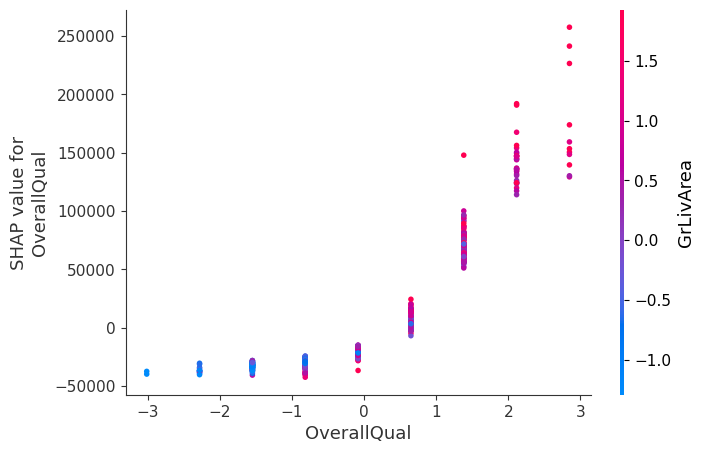

In [15]:
shap.dependence_plot('OverallQual', shap_values, X_train) 

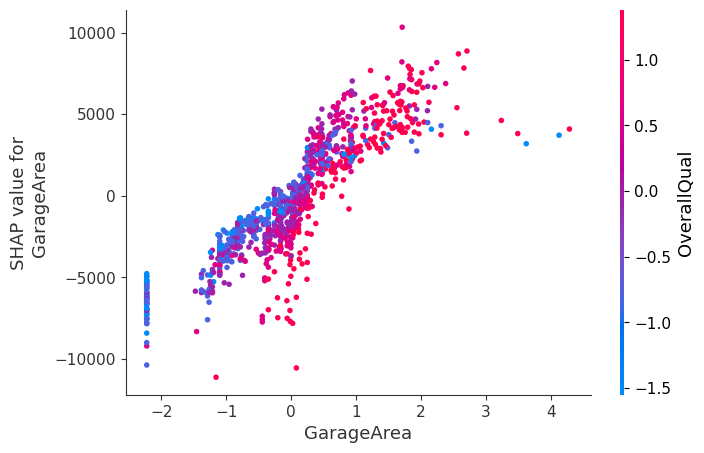

In [16]:
shap.dependence_plot('GarageArea', shap_values, X_train) 

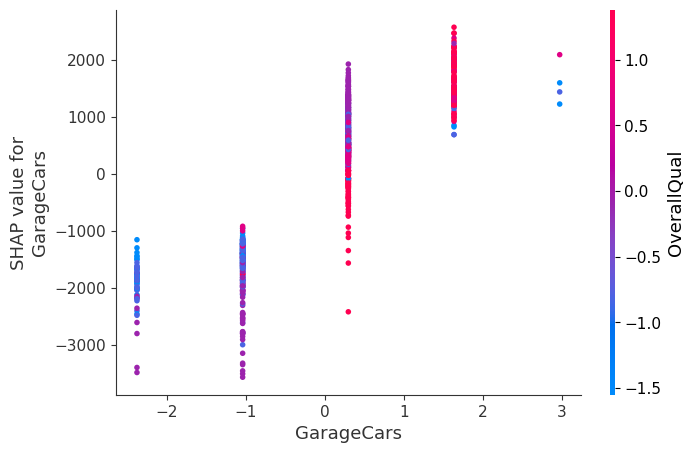

In [17]:
shap.dependence_plot('GarageCars', shap_values, X_train) 

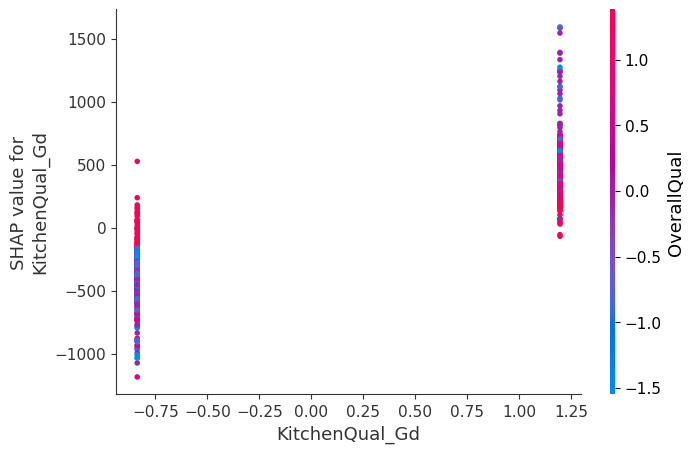

In [18]:
shap.dependence_plot('KitchenQual_Gd', shap_values, X_train) 

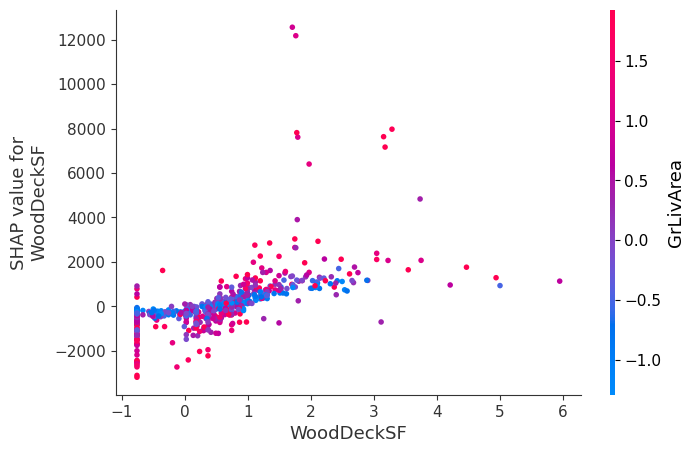

In [19]:
shap.dependence_plot('WoodDeckSF', shap_values, X_train) 

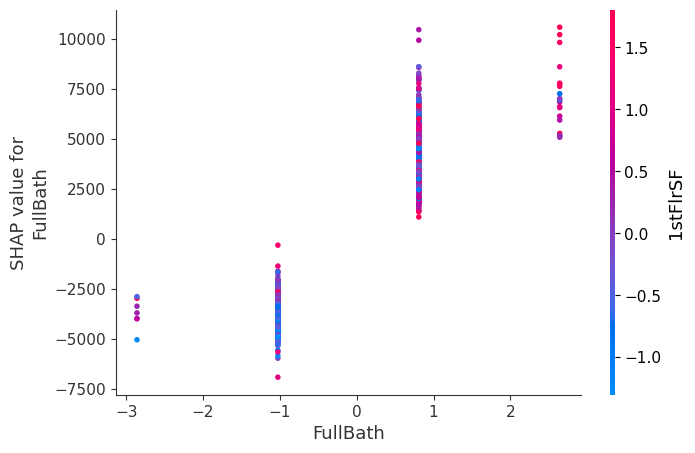

In [20]:
shap.dependence_plot('FullBath', shap_values, X_train) 

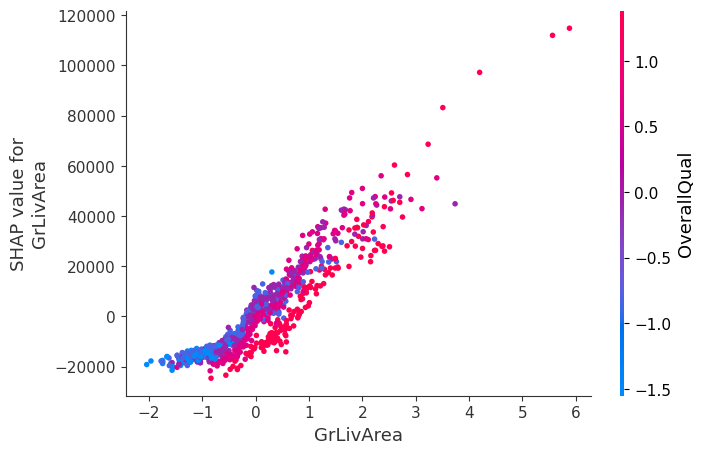

In [21]:
shap.dependence_plot('GrLivArea', shap_values, X_train) 

[<a href="#5.Advance Modeling Part B">Back to top</a>]

## 5.7 SHAP Decision <a id='5.7_Shap_Decision'></a>

The Decision Plot shows essentially the same information as the Force Plot. The grey vertical line is the base value and the red line indicates if each feature moved the output value to a higher or lower value than the average prediction.


In [22]:
feature_names = X_train.columns.tolist()

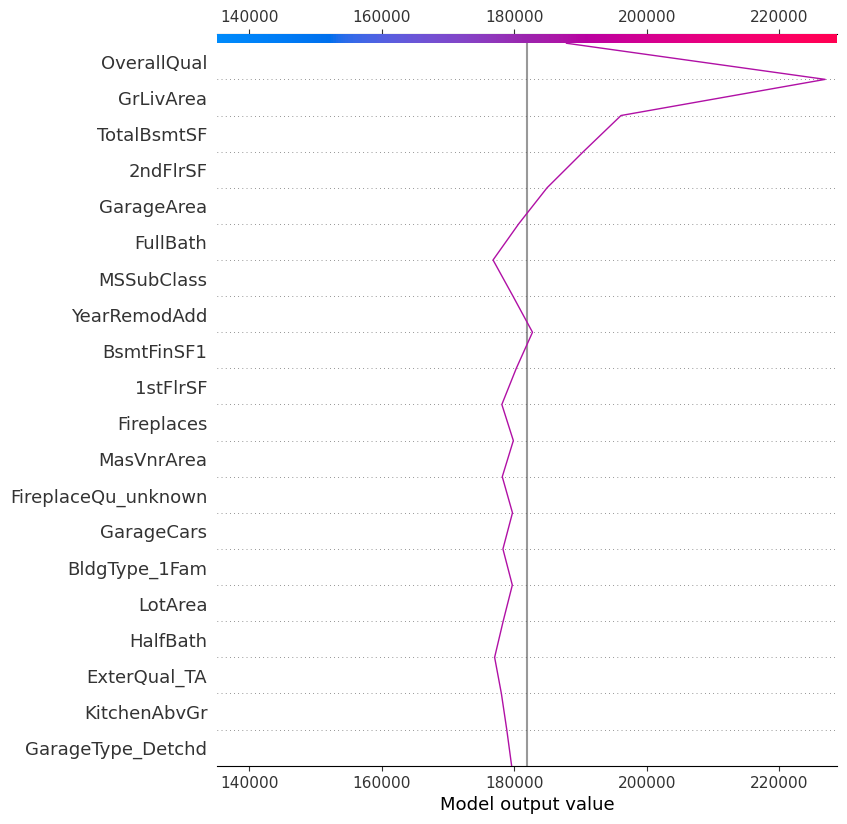

In [23]:
# Plot the SHAP decision plot
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names)

# Display the plot
plt.show()

## 5.8 SHAP Decision plot all features<a id='5.8_SHAP_Decision_plot_all_features'></a>

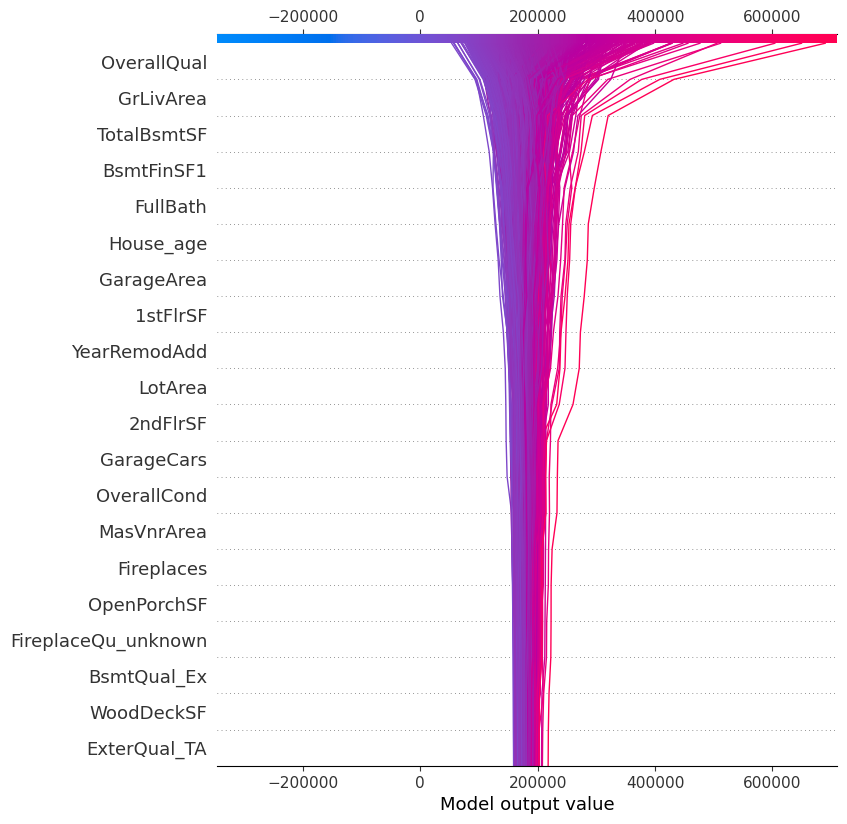

In [24]:
# Plot the SHAP decision plotwith all the features to look for out;iers
shap.decision_plot(explainer.expected_value, shap_values, feature_names=feature_names)

# Display the plot
plt.show()

## 5.9 SHAP force plot <a id='SHAP_force_plot'></a>


shap_values = explainer.shap_values(X_train.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values, X_train.iloc[0,:])

shap.force_plot(explainer.expected_value, shap_values, X_train)

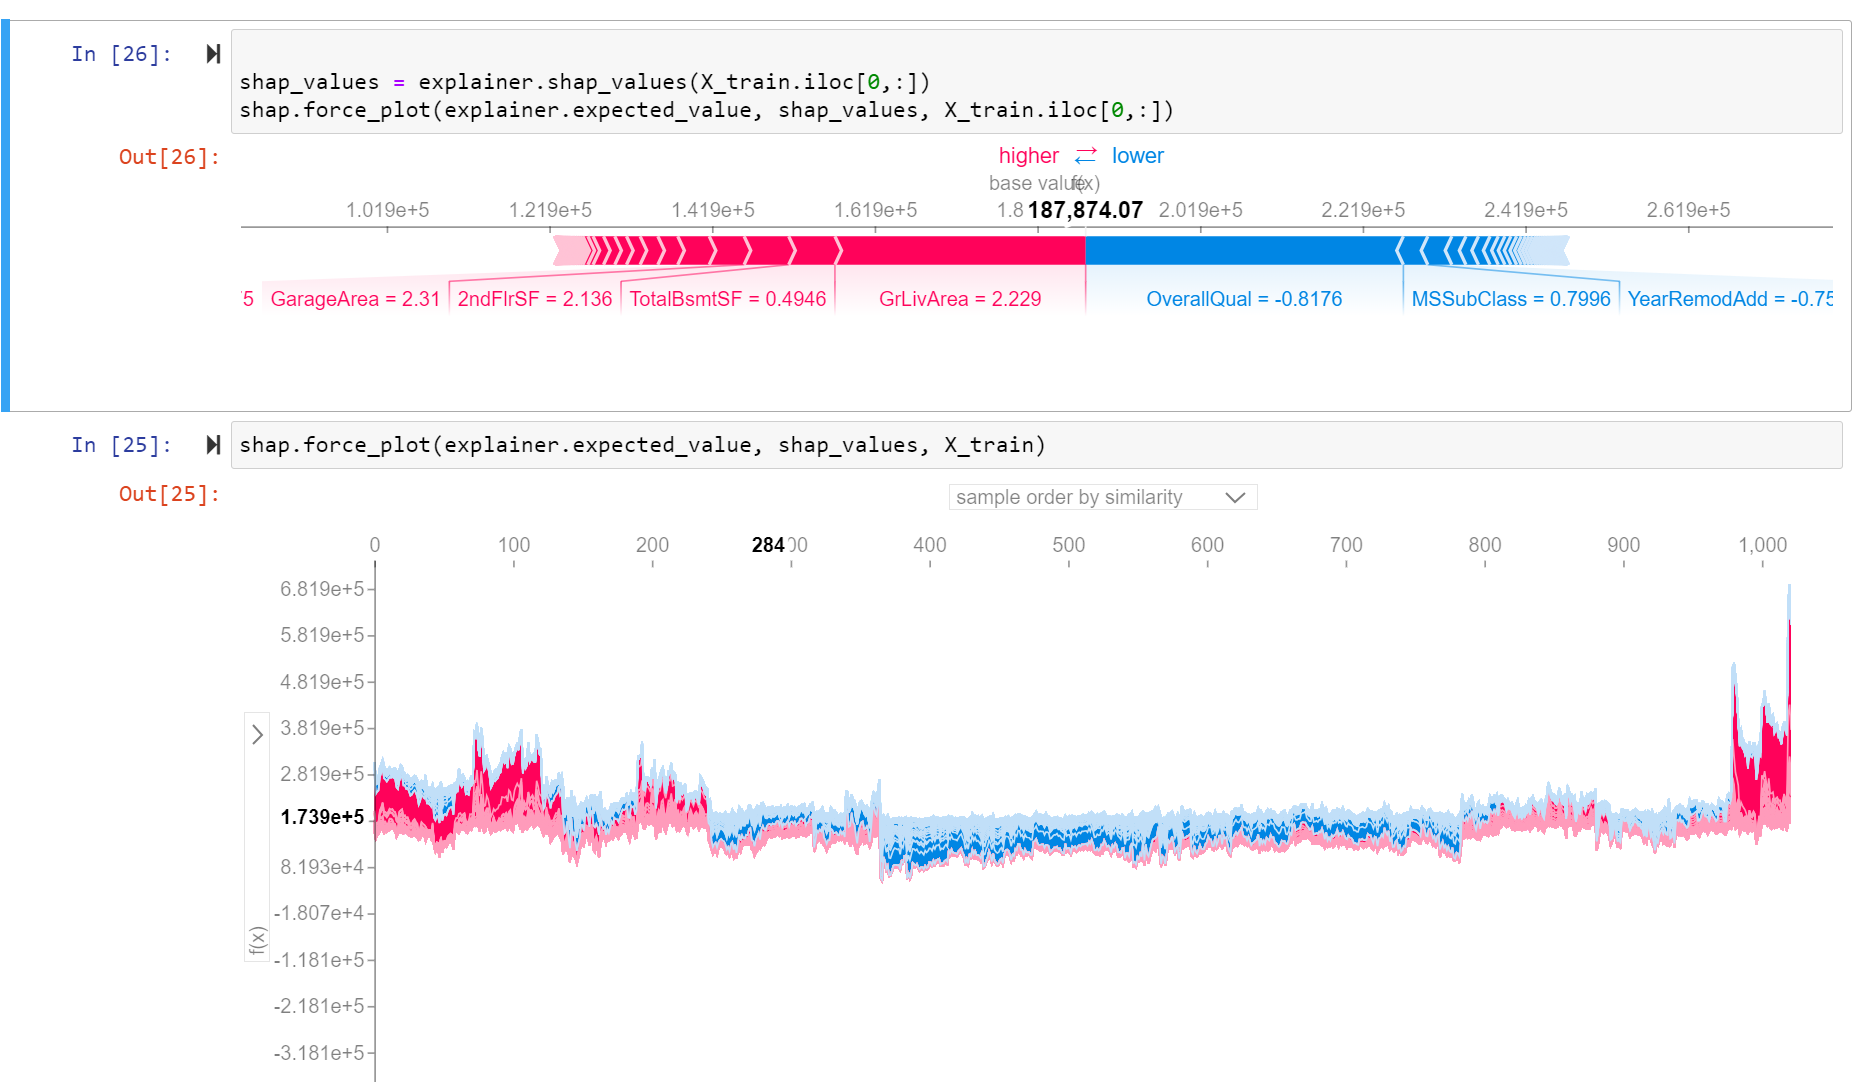

__From the FORCE plot we can see:__

*The model output value:$181,468.55
*The base value: this is the value that would be predicted if we didn’t know any features for the current instance. This is the average House Price over the training dataset.
*The numbers on the plot arrows are the value of the feature for this instance. GrLivArea=2.229 and RM,and OverallQual=-0.8176 
*Red represents features that pushed the model score higher, and blue representing features that pushed the score lower.
*The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.


## 5.10 Summary<a id='5.10_Summary'></a>

__SHAP Feature Importance Plot:__

The SHAP feature importance plot displays the top 20 features with their corresponding SHAP values, indicating their importance in predicting house prices.
The features are ranked in descending order based on their absolute SHAP values, representing their impact on the target variable (house price).
The plot reveals that the overall quality of the house has the highest positive correlation with the price, indicating that an improvement in __Overall quality leads to higher house prices.__
On the other hand, exterior quality has the least correlation with house prices, suggesting that it has a relatively smaller impact compared to other features.


__SHAP Summary Plot:__

The summary plot provides a concise visualization of the relationship between the overall quality of the house and other relevant features.
It displays the positive and negative correlations of different features with the overall quality.
__Ground living area and total basement square feet are prominently shown to have strong positive correlations with the overall quality, indicating that larger living areas and basements contribute to higher overall quality and subsequently higher house prices.__

__SHAP Dependence Plot:__

The SHAP dependence plot focuses on analyzing the relationship between the overall quality of the house and specific highly correlated features.
It provides a visual representation of how changes in these features affect the overall quality and subsequently influence house prices.
__For example, the plot may show that increasing the garage size, improving kitchen quality, or adding more wood deck square footage leads to higher overall quality and consequently higher house prices.
SHAP Decision Plot:__

__The SHAP decision plot__

investigates the effect of each feature on a specific target feature, such as the overall quality of the house.
It helps identify any outliers in the data by showcasing the influence of each feature on the target feature.
__The 2nd decision plot was used to examine if there were any significant outliers impacting the relationship between features and house prices. Fortunately, no notable outliers were found.__

__SHAP Force Plot:__

The SHAP force plot provides an intuitive visualization of the relationships between features and their impact on house prices.
It displays each feature's contribution to the predicted value of the target variable (house price) for individual instances.
By examining the force plot, one can understand how different features influence the predicted house price for specific instances in the dataset.

[<a href="#5.Advance Modeling Part B">Back to top</a>]